# 1 DataSet Construction

## 1.1 Components Data

In [6]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import yfinance as yf

### Scraping Index Components From BlackRock ETFs

In [7]:
"""
This notebook extracts Historical Data of the Stock Components of several ETF 
issued by _BlackRock_. A Long History (from 2006Q3) is Publicly Available for:
+ SP500 (IVV), 
+ SP100 (OEF), 
+ RUSSELL1000 (IWB), 
+ RUSSELL2000 (IWM), 
+ RUSSELL3000 (IWV).
_Vanguard_ site (the largest Global issuer for passive indexing) 
does not record historical data of index (ETF) components,
Moreover their corresponding ETFs were issued much later than year 2K
"""

import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import json

BLACKROCK_CL_URL_ROOT = "https://www.blackrock.com/cl/productos/"

def index_components_finder(symbol="IVV", path = "data/pkl/"):
    """Scrapes BlackRock website public component time-series data for supported financial ETF products.
    Args:
        tickers : {‘IVV’, 'OEF', ‘IWB’, ‘IWM’, ‘IWV’}, default ‘IVV’ (S&P500)
        path : str, default './data/pkl'
    """
    
    etf_url = {        
        "IVV": "239726/ishares-core-sp-500-etf", # iShares Core S&P 500 ETF
        "OEF": "239723/ishares-core-sp-100-etf", # iShares Core S&P 500 ETF
        "IWB": "239707/ishares-russell-1000-etf", # iShares Russell 1000 ETF
        "IWM": "239710/ishares-russell-2000-etf", # iShares Russell 2000 ETF
        "IWV": "239714/ishares-russell-3000-etf", # iShares Russell 3000 ETF
    }

    url = BLACKROCK_CL_URL_ROOT + etf_url[symbol] + "#tabsAll"    
    # request page
    html = requests.get(url).content
    soup = BeautifulSoup(html)

    # find available dates
    holdings = soup.find("div", {"id": "holdings"})
    dates_div = holdings.find_all("div", "component-date-list")[1]
    dates_div.find_all("option")
    dates = [option.attrs["value"] for option in dates_div.find_all("option")]

    # download constituents for each date
    constituents = pd.Series(dtype=object)
    for date in dates:
        resp = requests.get(BLACKROCK_CL_URL_ROOT
        +etf_url[symbol]
        +f"/1506433277024.ajax?tab=all&fileType=json&asOfDate={date}").content[3:]
        tickers = json.loads(resp)
        tickers = [(arr[0], arr[1]) for arr in tickers['aaData']]
        date = datetime.strptime(date, "%Y%m%d")
        constituents[date] = tickers

    constituents = constituents.iloc[::-1] # reverse into cronlogical order
    
    # for pickle filename construction and saving (serial date)
    last_date = constituents.index[-1].strftime("%Y%m%d")
    pklfile_fullpath = path + symbol + "_historical_components_" + last_date + ".pkl"    
    constituents.to_pickle(pklfile_fullpath)
    return constituents

## 1.2 **S&P100**: 10Y Survivors and Total Return Performance

In [8]:
oef = index_components_finder("OEF")

In [9]:
import time
import re

def change_ticker(ticker):
    rename_table = {
        "-": "LPRAX", # BlackRock LifePath Dynamic Retirement Fund
        "8686": "AFL", # AFLAC
        "4XS": "ESRX", # Express Scripts Holding Company 
        "AAZ": "APC", # Anadarko Petroleum Corporation
        "AG4": "AGN", # Allergan plc
        "BFB": "BF-B", # Brown-Forman Corporation
        "BF.B": "BF-B", # Brown-Forman Corporation
        "BF/B": "BF-B", # Brown-Forman Corporation
        "BF_B" : "BF-B", # Brown-Forman Corporation
        "BLD WI": "BLD", # TopBuild Corp.
        "BRKB": "BRK-B", # Berkshire Hathaway Inc.
        "BRK_B": "BRK-B", # Berkshire Hathaway Inc.
        "CC WI": "CC", # The Chemours Company
        "DC7": "DFS", # Discover Financial Services
        "DWDP": "DD", # Discover Financial Services
        "FB": "META",   # Facebook
        "GGQ7": "GOOG", # Alphabet Inc. Class C
        "GEC": "GE", # General Electric
        "HNZ": "KHC", # The Kraft Heinz Company
        "INCO": "INTC", # Intel
        "LOM": "LMT", # Lockheed Martin Corp.
        "LTD": "LB", # L Brands Inc.
        "LTR": "L", # Loews Corporation        
        "MPN": "MPC", # Marathon Petroleum Corp.
        "MYL": "VTRS", # Mylan NV (VIATRIS)
        "MWZ": "MET", # Metlife Inc.
        "MX4A": "CME", # CME Group Inc.
        "NCRA": "NWSA", # News Corporation
        "NTH": "NOC", # Northrop Grumman Crop.
        "PA9": "TRV", # The Travelers Companies, Inc.
        "QCI": "QCOM", # Qualcomm Inc.
        "RN7": "RF", # Regions Financial Corp
        "RTN" : "RTX", # Raytheon
        "SLBA": "SLB", # Schlumberger Limited
        "SYF-W": "SYF", # Synchrony Financial
        "SWG": "SCHW", # The Charles Schwab Corporation 
        "UAC/C": "UAA", # Under Armour Inc Class A
        "UBSFT": "UBSFY", # Ubisoft Entertainment
        "USX1": "X", # United States Steel Corporation
        "UUM": "UNM", # Unum Group
        "VISA": "V", # Visa Inc         
        "VIAC": "VIA", # viacom
        "WLTW": "WTW" # Willis Towers Watson                
    }
    if ticker in rename_table:
        fix = rename_table[ticker]
    else:
        fix = re.sub(r'[^A-Z]+', '', ticker)
    return fix

In [10]:
def all_times_symbols(financial_index, start_date, end_date):
    symbols = [change_ticker(elements[0]) for elements in financial_index[start_date:end_date][0]]
    all_symbols = symbols
    symbols = set(symbols)        

    for i, _ in enumerate(financial_index[start_date:end_date]):
        if i>0:
            sym = [change_ticker(stocks[0]) for stocks in financial_index[start_date:end_date][i]]        
            all_symbols.extend(sym)
            symbols = symbols.intersection(set(sym))
            
        else:
            continue
    return symbols, set(all_symbols)

In [11]:
tickers, all_tickers = all_times_symbols(oef, "2011-06-29", "2022-08-01")

In [12]:
var_symbols = all_tickers.difference(tickers)
print(var_symbols)

{'PCLN', 'OXY', 'CRM', 'AA', 'ADBE', 'AMT', 'AGN', 'ACT', 'ALL', 'XRX', 'WY', 'ABBV', 'TMO', 'ALD', 'DHR', 'XTSLA', 'FCX', 'WMB', 'KFT', 'KTF', 'EMC', 'KMI', 'KHC', 'MON', 'WBA', 'BAX', 'ESH', 'MDLZ', 'WPG', 'MSFUT', 'NVDA', 'OXYWSWI', 'AEP', 'SPG', 'ACN', 'ESZ', 'LPRAX', 'CHTR', 'CRC', 'AIG', 'UTX', 'DELL', 'FB', 'HAL', 'AVP', 'ETR', 'APA', 'HON', 'FOXA', 'SBUX', 'GOOG', 'SCHW', 'LLY', 'BLK', 'RTN', 'AXP', 'APC', 'CMCSK', 'RTX', 'META', 'ESU', 'BHI', 'HPQ', 'SLB', 'NEE', 'PYPL', 'S', 'FOX', 'BLKFDS', 'TSLA', 'GM', 'TMUS', 'BIIB', 'DUK', 'NOV', 'NWSA', 'DVN', 'WAG', 'CELG', 'CC', 'NFLX', 'USD', 'LIN', 'DOW', 'EBAY', 'TWX', 'AVGO', 'NSC', 'AEC', 'BKNG', 'ESM'}


In [13]:
len(var_symbols)

91

In [14]:
print(tickers)

{'NKE', 'WMT', 'UPS', 'TXN', 'MO', 'MMM', 'EMR', 'USB', 'CMCSA', 'COP', 'XOM', 'KO', 'AMGN', 'AAPL', 'QCOM', 'BRK-B', 'CSCO', 'CAT', 'F', 'T', 'JPM', 'UNP', 'PM', 'JNJ', 'IBM', 'DIS', 'GILD', 'PEP', 'V', 'FDX', 'PG', 'GOOGL', 'LMT', 'BMY', 'MS', 'C', 'GE', 'UNH', 'BAC', 'MDT', 'EXC', 'PFE', 'GD', 'BK', 'SO', 'BA', 'CVS', 'COF', 'DD', 'MRK', 'AMZN', 'MSFT', 'COST', 'ORCL', 'CL', 'MET', 'INTC', 'MA', 'MCD', 'HD', 'VZ', 'CVX', 'WFC', 'GS', 'ABT', 'TGT', 'LOW'}


In [15]:
data = yf.download(
    list(tickers), 
    start="2011-06-29", 
    end="2022-08-01"
)["Adj Close"]

[*********************100%***********************]  67 of 67 completed


In [16]:
data.head()

,AAPL,ABT,AMGN,AMZN,BA,BAC,BK,BMY,BRK-B,C,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2011-06-28,10.223415,19.818769,44.267136,10.1175,58.219566,9.173676,19.050795,20.295321,76.419998,33.617455,...,23.876259,43.582527,39.962994,51.654606,18.416531,17.383270,21.897718,20.037477,40.663376,50.620132
2011-06-29,10.186214,19.784637,43.610485,10.2090,58.728355,9.444983,19.797880,20.489155,77.029999,34.747799,...,23.801594,43.388912,40.461872,51.604416,18.757164,19.990294,21.987539,20.460230,40.748524,51.014267
2011-06-30,10.235918,19.959114,44.040684,10.2245,59.705536,9.292374,19.937962,20.790680,77.389999,34.865036,...,24.510859,43.422581,41.011848,52.285511,18.890461,19.456875,22.292921,20.452940,41.135574,51.732616
2011-07-01,10.467370,20.141180,43.987862,10.4745,59.980156,9.402595,20.280367,20.927078,78.089996,35.903282,...,25.026018,44.727444,41.938938,53.023937,19.297737,20.313572,22.634222,20.897573,41.422001,52.133080
2011-07-05,10.655519,20.163935,43.716137,10.6595,59.883205,9.326288,20.000216,20.934256,77.309998,35.643719,...,24.578058,44.491718,41.530384,52.894894,18.949701,20.394394,22.646204,20.715349,41.329090,51.872471


In [17]:
yfinance_exceptions = ['GAS', 'HAR', 'CSC', 'EMC', 'GME', 'POM', 'PCL', 'COV', 'ETN', 'COL', 'LLL']

In [18]:
set(data.columns).intersection(yfinance_exceptions)

set()

In [19]:
oef_daily_rets = data.pct_change()
oef_daily_rets

,AAPL,ABT,AMGN,AMZN,BA,BAC,BK,BMY,BRK-B,C,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2011-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-06-29,-0.003639,-0.001722,-0.014834,0.009044,0.008739,0.029575,0.039215,0.009551,0.007982,0.033624,...,-0.003127,-0.004442,0.012484,-0.000972,0.018496,0.149973,0.004102,0.021098,0.002094,0.007786
2011-06-30,0.004879,0.008819,0.009865,0.001518,0.016639,-0.016158,0.007076,0.014716,0.004674,0.003374,...,0.029799,0.000776,0.013592,0.013198,0.007106,-0.026684,0.013889,-0.000356,0.009499,0.014081
2011-07-01,0.022612,0.009122,-0.001199,0.024451,0.004600,0.011861,0.017174,0.006561,0.009045,0.029779,...,0.021018,0.030050,0.022605,0.014123,0.021560,0.044031,0.015310,0.021739,0.006963,0.007741
2011-07-05,0.017975,0.001130,-0.006177,0.017662,-0.001616,-0.008115,-0.013814,0.000343,-0.009988,-0.007230,...,-0.017900,-0.005270,-0.009742,-0.002434,-0.018035,0.003979,0.000529,-0.008720,-0.002243,-0.004999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25,-0.007398,-0.006410,0.011262,-0.010456,-0.009611,0.008974,0.007022,-0.001508,0.007205,0.004816,...,-0.004271,0.015458,0.018557,-0.000372,0.007126,0.002667,0.006974,0.007644,-0.001437,0.033303
2022-07-26,-0.008826,0.005438,0.009730,-0.052254,-0.004597,-0.020160,-0.021153,0.010846,-0.009306,-0.014571,...,-0.014461,0.004004,-0.006395,-0.033952,-0.013111,-0.008307,0.003575,-0.013793,-0.076049,-0.003890
2022-07-27,0.034235,0.008250,0.002309,0.053654,0.001090,0.016339,0.018285,0.016026,0.017490,0.018482,...,0.066526,0.005681,0.018151,0.013056,0.016660,-0.009506,-0.000223,0.018881,0.037793,0.021645


In [20]:
start_date = oef_daily_rets.index[0].strftime("%Y-%m-%d")
end_date = oef_daily_rets.index[-1].strftime("%Y-%m-%d")

In [21]:
eqwl_prices = yf.download("EQWL", start=start_date, end=end_date)["Adj Close"]
eqwl_prices /= eqwl_prices[0]

[*********************100%***********************]  1 of 1 completed


In [22]:
surv_eqwl_daily_rets = oef_daily_rets
surv_eqwl_daily_rets

,AAPL,ABT,AMGN,AMZN,BA,BAC,BK,BMY,BRK-B,C,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2011-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-06-29,-0.003639,-0.001722,-0.014834,0.009044,0.008739,0.029575,0.039215,0.009551,0.007982,0.033624,...,-0.003127,-0.004442,0.012484,-0.000972,0.018496,0.149973,0.004102,0.021098,0.002094,0.007786
2011-06-30,0.004879,0.008819,0.009865,0.001518,0.016639,-0.016158,0.007076,0.014716,0.004674,0.003374,...,0.029799,0.000776,0.013592,0.013198,0.007106,-0.026684,0.013889,-0.000356,0.009499,0.014081
2011-07-01,0.022612,0.009122,-0.001199,0.024451,0.004600,0.011861,0.017174,0.006561,0.009045,0.029779,...,0.021018,0.030050,0.022605,0.014123,0.021560,0.044031,0.015310,0.021739,0.006963,0.007741
2011-07-05,0.017975,0.001130,-0.006177,0.017662,-0.001616,-0.008115,-0.013814,0.000343,-0.009988,-0.007230,...,-0.017900,-0.005270,-0.009742,-0.002434,-0.018035,0.003979,0.000529,-0.008720,-0.002243,-0.004999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25,-0.007398,-0.006410,0.011262,-0.010456,-0.009611,0.008974,0.007022,-0.001508,0.007205,0.004816,...,-0.004271,0.015458,0.018557,-0.000372,0.007126,0.002667,0.006974,0.007644,-0.001437,0.033303
2022-07-26,-0.008826,0.005438,0.009730,-0.052254,-0.004597,-0.020160,-0.021153,0.010846,-0.009306,-0.014571,...,-0.014461,0.004004,-0.006395,-0.033952,-0.013111,-0.008307,0.003575,-0.013793,-0.076049,-0.003890
2022-07-27,0.034235,0.008250,0.002309,0.053654,0.001090,0.016339,0.018285,0.016026,0.017490,0.018482,...,0.066526,0.005681,0.018151,0.013056,0.016660,-0.009506,-0.000223,0.018881,0.037793,0.021645


In [23]:
eqwl_prices

Date
2011-06-27    1.000000
2011-06-28    1.007281
2011-06-29    1.016990
2011-06-30    1.027913
2011-07-01    1.042071
                ...   
2022-07-22    3.743753
2022-07-25    3.759403
2022-07-26    3.722046
2022-07-27    3.794235
2022-07-28    3.825534
Name: Adj Close, Length: 2791, dtype: float64

<AxesSubplot:xlabel='Date'>

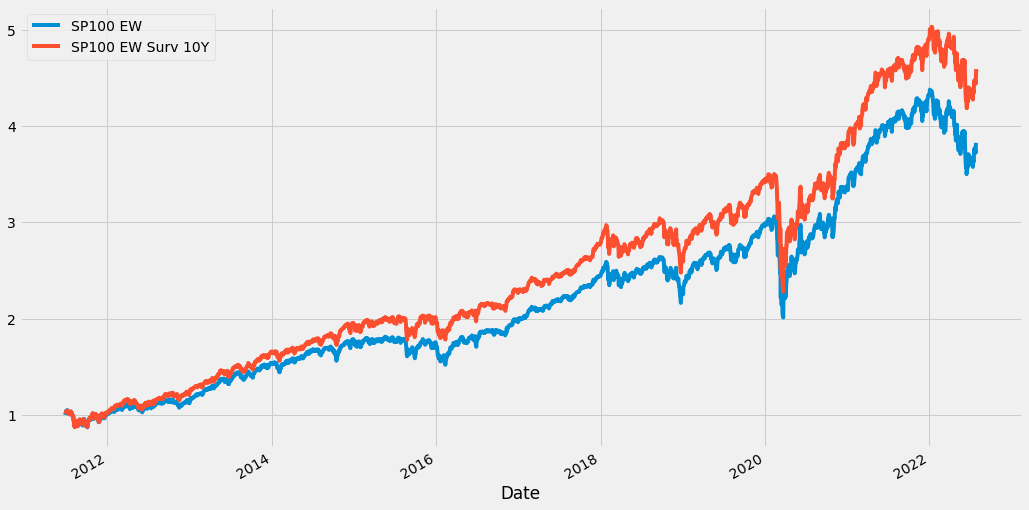

In [24]:
eqwl_prices.rename("SP100 EW").plot(figsize=(16,9), legend=True)
(1+surv_eqwl_daily_rets.mean(axis=1)).rename("SP100 EW Surv 10Y").cumprod().plot(legend=True)

In [25]:
eqwl_daily_rets = eqwl_prices.pct_change()
eqwl_daily_rets

Date
2011-06-27         NaN
2011-06-28    0.007281
2011-06-29    0.009639
2011-06-30    0.010740
2011-07-01    0.013774
                ...   
2022-07-22   -0.006298
2022-07-25    0.004180
2022-07-26   -0.009937
2022-07-27    0.019395
2022-07-28    0.008249
Name: Adj Close, Length: 2791, dtype: float64

In [26]:
surv_eqwl_total_return = (1+surv_eqwl_daily_rets.mean(axis=1)).cumprod()[-1]-1
eqwl_total_return = (1+eqwl_daily_rets+0.002/252).cumprod()[-1]-1

In [27]:
yld_surv_eqwl = 100*(surv_eqwl_total_return**.1 -1)
yld_eqwl = 100*(eqwl_total_return**.1 -1)
print(f"1Y Yield Equivalent 10Y Survivors of S&P100: {yld_surv_eqwl}%")
print(f"1Y Yield Equivalent $EQWL (SP100 EW): {yld_eqwl}%")

1Y Yield Equivalent 10Y Survivors of S&P100: 13.641571218756576%
1Y Yield Equivalent $EQWL (SP100 EW): 11.27726906355402%


In [28]:
surv_eqwl_cumreturn = (1+surv_eqwl_daily_rets.mean(axis=1)).cumprod()-1
eqwl_cumreturn = (1+eqwl_daily_rets+0.002/252).cumprod()-1

In [29]:
100*surv_eqwl_daily_rets.mean(axis=1).mean(axis=0)*252

15.297049851742893

In [30]:
100*eqwl_daily_rets.mean()*252

13.51016582548555

In [31]:
import numpy as np
100*surv_eqwl_daily_rets.mean(axis=1).std(axis=0)*np.sqrt(252)

17.430837117911544

In [32]:
100*eqwl_daily_rets.std()*np.sqrt(252)

16.624266226876898

In [33]:
SR = surv_eqwl_daily_rets.mean(axis=1).mean(axis=0)*252 / (surv_eqwl_daily_rets.mean(axis=1).std(axis=0)*np.sqrt(252))
SR0 = eqwl_daily_rets.mean()*252 / (eqwl_daily_rets.std()*np.sqrt(252))
print(SR)
print(SR0)

0.8775854967988875
0.8126774223359888


In [39]:
sp100_composition_ini = [change_ticker(sym[0]) for sym in oef[0]]
sp100_composition_fin = [change_ticker(sym[0]) for sym in oef[-1]]

In [40]:
sp100_survivalists = set(sp100_composition_ini).intersection(set(sp100_composition_fin))
len(sp100_survivalists)

48

In [41]:
sp100_after2012Q2 = oef[oef.index>"2012-06-01"]
sp100_after2012Q2

2012-06-29    [(-, BLACKROCK FDS III), (ALL, ALLSTATE CORP),...
2012-07-31    [(-, BLACKROCK FDS III), (ALL, ALLSTATE CORP),...
2012-08-31    [(-, BLACKROCK FDS III), (DELL, DELL INC.), (H...
2012-09-28    [(AAPL*, APPLE INC), (XOM, EXXON MOBIL CORP), ...
2012-10-31    [(AAPL*, APPLE INC), (XOM, EXXON MOBIL CORP), ...
                                    ...                        
2022-05-31    [(AAPL, APPLE INC), (MSFT, MICROSOFT CORP), (A...
2022-06-30    [(AAPL, APPLE INC), (MSFT, MICROSOFT CORP), (A...
2022-07-29    [(AAPL, APPLE INC), (MSFT, MICROSOFT CORP), (A...
2022-08-31    [(AAPL, APPLE INC), (MSFT, MICROSOFT CORP), (A...
2022-09-08    [(AAPL, APPLE INC), (MSFT, MICROSOFT CORP), (A...
Length: 119, dtype: object

In [47]:
sp100_after2012Q2_composition = set([change_ticker(sym[0]) for sym in sp100_after2012Q2[0]])
sp100_composition_fin = set(sp100_composition_fin)

In [43]:
type(sp100_after2012Q2_composition)

set

In [48]:
sp100_10y_survivalists = sp100_after2012Q2_composition.intersection(sp100_composition_fin)

In [51]:
len(sp100_10y_survivalists)

73

### Completing the SP100 with SP500 15Y+ Survivors


In [381]:
ivv = index_components_finder("IVV") # The Market Cap Weighted SP500 ETF (BlackRock Issued)

* 15Y+ **Survivalists**:

In [385]:
composition_ini = [change_ticker(sym[0]) for sym in ivv[0]]
composition_fin = [change_ticker(sym[0]) for sym in ivv[-1]]
sp500_survivalists = set(composition_ini).intersection(set(composition_fin))
len(sp500_survivalists)

248

In [78]:
raw_returns = pd.read_csv(
    "data/config/20220814_daily_raw_returns_merged.csv", 
    index_col="Date", 
    parse_dates=True,
    na_values="#N/A"
)

In [386]:
oef

2006-09-29    [(UIS, UNISYS CORP), (RSHCQ, RS LEGACY CORP), ...
2006-10-31    [(RSHCQ, RS LEGACY CORP), (OMX, OFFICEMAX INC....
2006-11-30    [(OMX, OFFICEMAX INC.), (BDK, THE BLACK & DECK...
2006-12-29    [(BGIXX, BLK CASH FUND INST INST CLASS), (BDK,...
2007-01-31    [(BDK, THE BLACK & DECKER CORPORATION), (NSM.2...
                                    ...                        
2022-05-31    [(AAPL, APPLE INC), (MSFT, MICROSOFT CORP), (A...
2022-06-30    [(AAPL, APPLE INC), (MSFT, MICROSOFT CORP), (A...
2022-07-29    [(AAPL, APPLE INC), (MSFT, MICROSOFT CORP), (A...
2022-08-31    [(AAPL, APPLE INC), (MSFT, MICROSOFT CORP), (A...
2022-09-08    [(AAPL, APPLE INC), (MSFT, MICROSOFT CORP), (A...
Length: 188, dtype: object

In [106]:
sp500_surv_prices = yf.download(
    list(sp500_survivalists), 
    ivv.index[0], 
    ivv.index[-1]
)["Adj Close"]

[*********************100%***********************]  248 of 248 completed


In [110]:
sp500_surv_prices.isna().sum().sort_values(ascending=False).head(25)

CEG     3853
DOW     3138
IR      2673
KHC     2205
HLT     1814
NWSA    1691
HCA     1119
KMI     1101
DG       788
NKE        0
NTAP       0
NSC        0
NOC        0
NI         0
NUE        0
NEM        0
NEE        0
MU         0
MSFT       0
NTRS       0
A          0
NVDA       0
NWL        0
MRO        0
OMC        0
dtype: int64

In [111]:
from modules import performance_measures_helper as pms

In [116]:
pms.net_cumreturn(sp500_surv_prices.pct_change(), last_row=True).sort_values(ascending=False).head(52)

AMZN     80.331655
AAPL     65.412818
NVDA     29.312903
AZO      20.087053
SHW      14.784241
COST     13.807715
EL       13.710640
INTU     13.681736
TMO      13.624752
UNP      13.406811
KLAC     12.674769
CTAS     12.216009
MSFT     12.012860
NEE      11.782890
UNH      11.756628
HD       11.165947
NKE      11.012426
DE       10.908181
CSX      10.730843
DG       10.698479
TJX      10.345748
NOC      10.341632
DHR      10.319440
GWW      10.287544
GOOGL     9.837063
MCD       9.496241
VRSN      9.480269
AON       9.235965
CMI       9.171822
ADBE      8.906600
ADP       8.508120
STZ       8.482107
LLY       8.252102
LOW       8.216111
HCA       7.915167
PGR       7.913637
FISV      7.869784
MMC       7.565162
ABC       7.425996
AMP       7.375102
YUM       7.307929
NSC       7.097216
HUM       7.021534
PKI       7.017957
CMS       6.943051
LMT       6.906942
MCK       6.892651
CI        6.775979
ADI       6.594815
WM        6.367221
SNA       6.274029
DTE       6.160004
Name: 2022-0

In [117]:
sp100_suplement = set(sp500_survivalists).difference(set(sp100_survivalists))
print(sp100_suplement)

{'CMA', 'NKE', 'EFX', 'OXY', 'ETN', 'KR', 'D', 'HSY', 'CCL', 'ROK', 'QCOM', 'AAPL', 'HES', 'HAS', 'ADBE', 'PEG', 'DOV', 'LEN', 'WHR', 'NOC', 'ALL', 'INTU', 'WY', 'ADI', 'AVY', 'UNH', 'FISV', 'PGR', 'HCA', 'TJX', 'MU', 'TMO', 'PH', 'TSN', 'DHR', 'EA', 'AMD', 'CME', 'CSX', 'XEL', 'DRI', 'TRV', 'NTAP', 'DTE', 'FCX', 'NEM', 'ADP', 'WMB', 'VLO', 'LOW', 'MCK', 'KMI', 'CB', 'ED', 'FITB', 'EMN', 'ADM', 'ZBH', 'EL', 'BAX', 'SYY', 'PHM', 'NVDA', 'KLAC', 'AEP', 'SPG', 'CMI', 'AMAT', 'HBAN', 'SEE', 'GILD', 'LH', 'A', 'GOOGL', 'LUMN', 'IPG', 'TXT', 'CINF', 'KIM', 'GPC', 'ITW', 'HAL', 'PAYX', 'MMC', 'OMC', 'KEY', 'DHI', 'PFG', 'ETR', 'APA', 'NTRS', 'MAR', 'PCAR', 'SBUX', 'GIS', 'SCHW', 'LLY', 'AES', 'CTXS', 'GLW', 'DG', 'NWL', 'COP', 'PNC', 'AON', 'PSA', 'HIG', 'UNP', 'AMP', 'NUE', 'RHI', 'SYK', 'PRU', 'WM', 'HLT', 'VMC', 'APD', 'BDX', 'LMT', 'SRE', 'HPQ', 'VRSN', 'AEE', 'SLB', 'BEN', 'PKI', 'CNP', 'NEE', 'CLX', 'BK', 'BXP', 'IP', 'TER', 'LUV', 'COF', 'AMZN', 'VNO', 'STT', 'MRO', 'MET', 'SHW', 'PPG'

In [120]:
sp100_suplement =list(sp100_suplement)

In [127]:
sp100_suplement_totalret = pms.net_cumreturn(sp500_surv_prices[sp100_suplement].pct_change(),last_row=True)
sp100_suplement_totalret.sort_values(ascending=False).head(52).index

Index(['AMZN', 'AAPL', 'NVDA', 'AZO', 'SHW', 'COST', 'EL', 'INTU', 'TMO',
       'UNP', 'KLAC', 'CTAS', 'NEE', 'UNH', 'NKE', 'DE', 'CSX', 'DG', 'TJX',
       'NOC', 'DHR', 'GWW', 'GOOGL', 'VRSN', 'AON', 'CMI', 'ADBE', 'ADP',
       'STZ', 'LLY', 'LOW', 'HCA', 'PGR', 'FISV', 'MMC', 'ABC', 'AMP', 'YUM',
       'NSC', 'HUM', 'PKI', 'CMS', 'LMT', 'MCK', 'CI', 'ADI', 'WM', 'SNA',
       'DTE', 'PH', 'PSA', 'AMAT'],
      dtype='object')

In [128]:
sp100_suplement = set(_)

In [132]:
len(sp100_survivalists.union(sp100_suplement))

100

In [133]:
enhanced_sp100 = sp100_survivalists.union(sp100_suplement)

In [148]:
enhanced_sp100_prices = yf.download(
    list(enhanced_sp100),
    start = oef.index[0],
    end = oef.index[-1],
)["Adj Close"]

[*********************100%***********************]  100 of 100 completed


In [153]:
stock_with_null_ts_data = list(enhanced_sp100_prices.isna().sum()[enhanced_sp100_prices.isna().sum()!=0].index)

In [155]:
enhanced_sp100_prices.drop(columns=stock_with_null_ts_data, inplace=True)

In [158]:
enhanced_sp100_cumreturn = (1+enhanced_sp100_prices.pct_change().mean(axis=1)).cumprod()

In [161]:
eqwl_price = yf.download(
    tickers="EQWL",
    start = oef.index[0],
    end=oef.index[-1]
)["Adj Close"]

[*********************100%***********************]  1 of 1 completed


In [162]:
eqwl_cumreturn = (1+eqwl_price.pct_change()).cumprod()

In [169]:
sp100_survivalists = list(sp100_survivalists).remove("KHC")

In [164]:
sp100_survivalists

{'ABT',
 'AIG',
 'AMGN',
 'BA',
 'BAC',
 'BMY',
 'CAT',
 'CL',
 'CMCSA',
 'CSCO',
 'CVX',
 'DD',
 'DIS',
 'DOW',
 'EXC',
 'F',
 'FDX',
 'GD',
 'GE',
 'GS',
 'HD',
 'IBM',
 'INTC',
 'JNJ',
 'JPM',
 'KHC',
 'KO',
 'MCD',
 'MDT',
 'MMM',
 'MO',
 'MRK',
 'MS',
 'MSFT',
 'ORCL',
 'PEP',
 'PFE',
 'PG',
 'SO',
 'T',
 'TGT',
 'TXN',
 'UPS',
 'USB',
 'VZ',
 'WFC',
 'WMT',
 'XOM'}

In [173]:
sp100_survs = set(sp100_composition_ini).intersection(set(sp100_composition_fin))

In [175]:
sp100_survs = list(sp100_survs)
len(sp100_survs)

48

In [176]:
sp100_survs.remove("KHC")

In [177]:
sp100_survs.remove("DOW")

In [178]:
len(sp100_survs)

46

<AxesSubplot:xlabel='Date'>

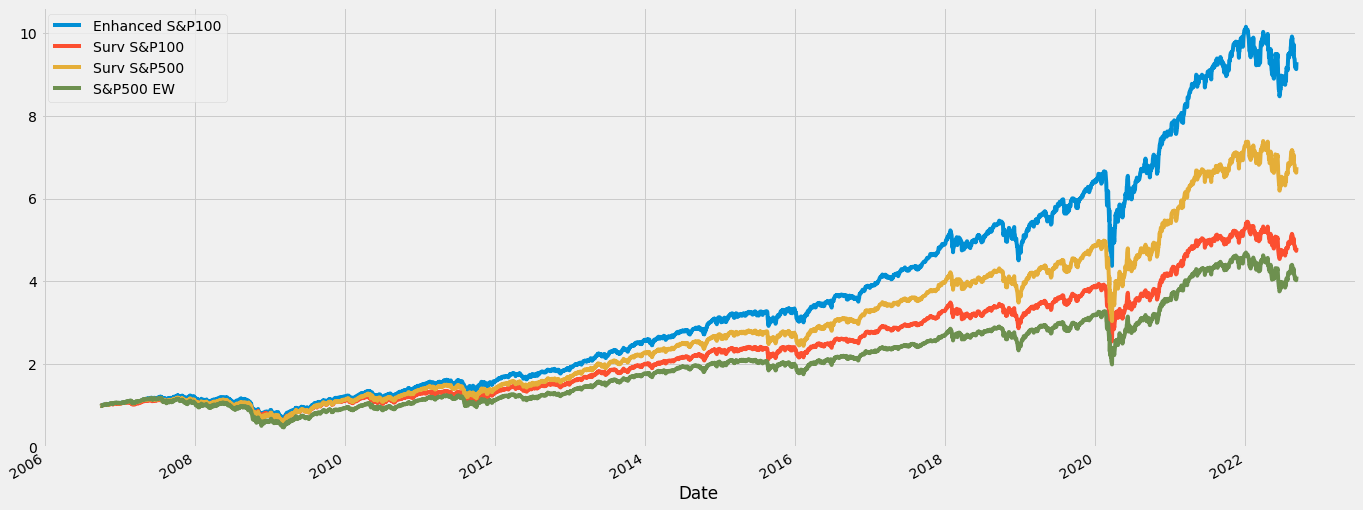

In [193]:
enhanced_sp100_cumreturn.rename("Enhanced S&P100").plot(figsize=(21,9), legend=True)
(1+enhanced_sp100_prices[sp100_survs].pct_change().mean(skipna=True, axis=1)).cumprod().rename("Surv S&P100").plot(legend=True)
(1+sp500_surv_prices.pct_change().mean(skipna=True, axis=1)).cumprod().rename("Surv S&P500").plot(legend=True)
(1+rsp.pct_change()).cumprod().rename("S&P500 EW").plot(legend=True)

## 1.3 **S&P500** Enhancing

We propose supplement _S&P500_ non-survivors with stocks belonging from _Russell 3000_ and surviving all the sample.

* Caching Stock from **Russell 3000** Surviving From 2006-09 _End-Of-Month_


In [ ]:
iwv = index_components_finder("IWV")
composition_ini = [change_ticker(sym[0]) for sym in iwv[0]]
composition_fin = [change_ticker(sym[0]) for sym in iwv[-1]]
tf3000 = set(composition_ini).intersection(set(composition_fin)) # TF:= Russell mnemonic
len(tf3000)

In [203]:
sp500_supplementary = tf3000.symmetric_difference(sp500_survivalists)
len(sp500_supplementary)

912

In [204]:
sp500_supplementary_prices = yf.download(
    tickers=list(sp500_supplementary),
    start = ivv.index[0],
    end=ivv.index[-1],
    progress=False,
    show_errors=True
)


4 Failed downloads:
- GTXI: No data found, symbol may be delisted
- PN: No data found for this date range, symbol may be delisted
- ARD: No data found, symbol may be delisted
- MOGA: No data found, symbol may be delisted


In [206]:
sp500_supplementary_prices = sp500_supplementary_prices["Adj Close"]

In [213]:
# Dropping Stocks With Missing Quotes
tf3000_stocks_nulldata = list(sp500_supplementary_prices.isna().sum()[sp500_supplementary_prices.isna().sum()!=0].index)

In [214]:
len(tf3000_stocks_nulldata)

80

In [215]:
sp500_supplementary_prices.drop(columns=tf3000_stocks_nulldata, inplace=True)
sp500_supplementary_prices.isna().sum().sum()

0

In [216]:
len(sp500_supplementary_prices.columns)

832

In [228]:
sp500_supplementary_totalrets = pms.net_cumreturn(sp500_supplementary_prices.pct_change(),last_row=True)

<AxesSubplot:xlabel='Date'>

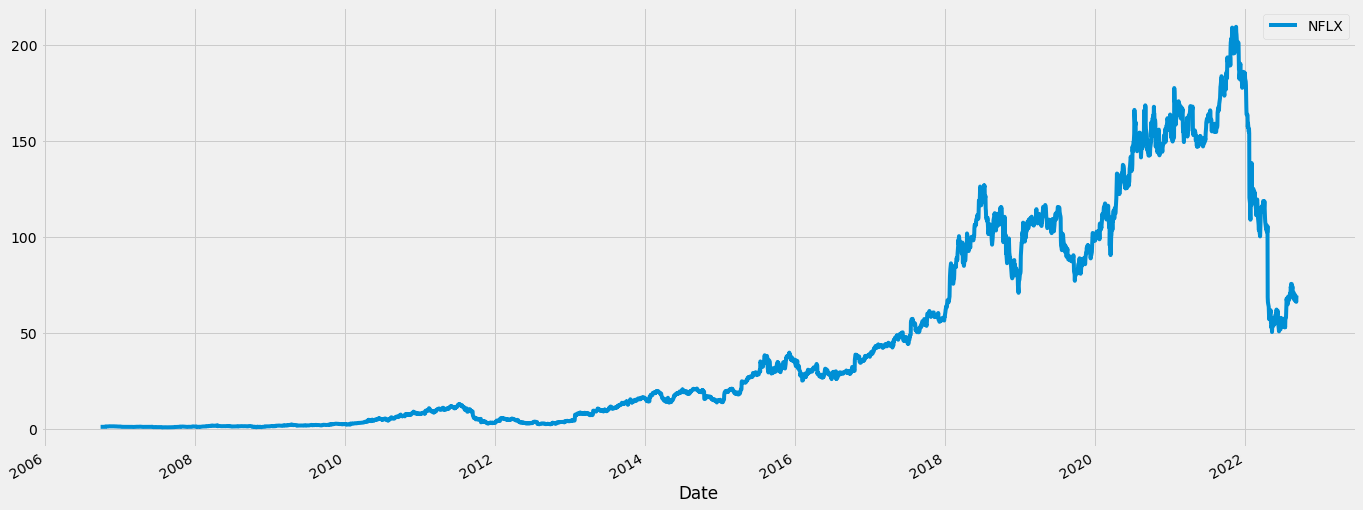

In [221]:
(1+sp500_supplementary_prices[["NFLX"]].pct_change()).cumprod().plot(figsize=(21,9))

In [224]:
pms.net_cumreturn(rsp.pct_change(), last_row=True)

3.116607099159956

In [232]:
sp500_supplementary_totalrets[sp500_supplementary_totalrets<3].sort_values(ascending=False).head(252)

GPI     2.998731
SJI     2.998545
TKR     2.995537
LSTR    2.958166
EXTR    2.957507
          ...   
EFSC    0.861323
FORR    0.860403
UBSI    0.855568
ROCK    0.847137
RNST    0.841963
Name: 2022-09-07 00:00:00, Length: 252, dtype: float64

In [265]:
sp500_added_stocks = list(sp500_supplementary_totalrets[sp500_supplementary_totalrets<0.42054349065539876].sort_values(ascending=False).head(252).index)

In [276]:
sp500_added_stocks2 = list(sp500_supplementary_totalrets.sort_values().head(252).index)

<AxesSubplot:xlabel='Date'>

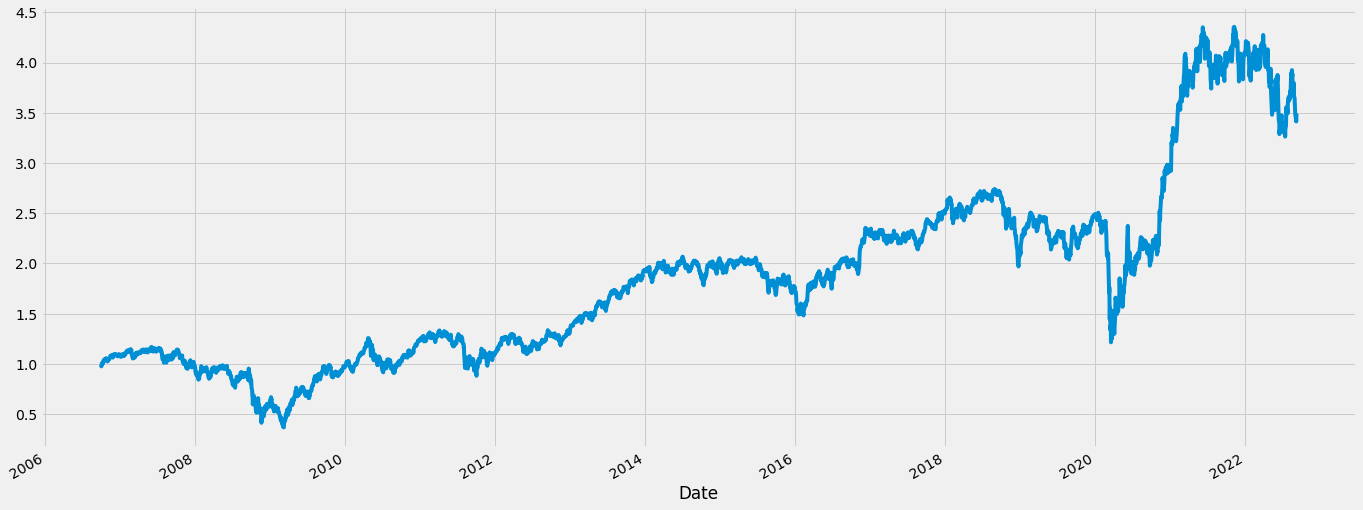

In [277]:
(1+sp500_supplementary_prices[sp500_added_stocks2].pct_change().mean(skipna=True, axis=1)).cumprod().plot(figsize=(21,9))

In [278]:
sp500_enhanced2_stocks = set(sp500_survivalists).union(set(sp500_added_stocks2))
len(sp500_enhanced2_stocks)

498

In [264]:
pms.net_cumreturn(sp500_surv_prices.pct_change(),last_row=True).quantile(.10)

0.42054349065539876

In [279]:
sp500_enhanced2_prices = yf.download(
    list(sp500_enhanced2_stocks),
    start=ivv.index[0],
    end=ivv.index[-1],
)

[*********************100%***********************]  498 of 498 completed


In [ ]:
rsp = yf.download(
    tickers="RSP",
    start = ivv.index[0],
    end = ivv.index[-1],
)["Adj Close"]

In [280]:
sp500_enhanced2_prices = sp500_enhanced2_prices["Adj Close"]

<AxesSubplot:xlabel='Date'>

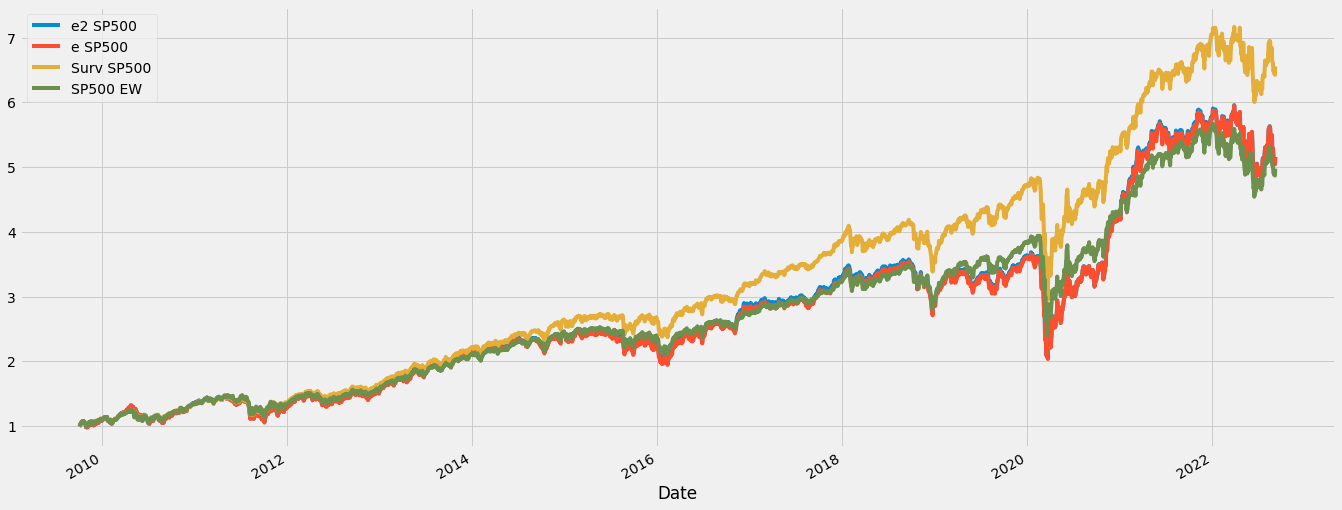

In [284]:
(1+sp500_enhanced2_prices["2009-10-1":].pct_change().mean(skipna=True,axis=1)).rename("e2 SP500").cumprod().plot(figsize=(21,9), legend=True)
(1+sp500_enhanced1_prices["2009-10-1":].pct_change().mean(skipna=True,axis=1)).rename("e SP500").cumprod().plot(figsize=(21,9), legend=True)
(1+sp500_surv_prices["2009-10-1":].pct_change().mean(skipna=True,axis=1)).rename("Surv SP500").cumprod().plot(figsize=(21,9), legend=True)
(1+rsp["2009-10-1":].pct_change()+0.002/252).rename("SP500 EW").cumprod().plot(legend=True)

In [262]:
rsp

Date
2006-09-28     34.623173
2006-09-29     34.491192
2006-10-02     34.444584
2006-10-03     34.359180
2006-10-04     34.825054
                 ...    
2022-08-31    140.759995
2022-09-01    140.880005
2022-09-02    139.860001
2022-09-06    139.470001
2022-09-07    142.529999
Name: Adj Close, Length: 4013, dtype: float64

In [290]:
sp500_enhancend_missing_data_stocks = list(sp500_enhanced2_prices.isna().sum()[sp500_enhanced2_prices.isna().sum()!=0].index)

In [291]:
sp500_enhancend_missing_data_stocks


['CEG', 'DG', 'DOW', 'HCA', 'HLT', 'IR', 'KHC', 'KMI', 'NWSA']

In [293]:
sp500_enhanced2_prices.drop(columns=sp500_enhancend_missing_data_stocks, inplace=True)
sp500_enhanced2_prices.isna().sum().sum()

0

In [294]:
sp500_enhanced2_prices.columns

Index(['A', 'AA', 'AAPL', 'ABC', 'ABT', 'ACCO', 'ADBE', 'ADI', 'ADM', 'ADP',
       ...
       'WY', 'X', 'XEL', 'XOM', 'XRAY', 'XRX', 'YUM', 'ZBH', 'ZION', 'ZUMZ'],
      dtype='object', length=489)

<AxesSubplot:xlabel='Date'>

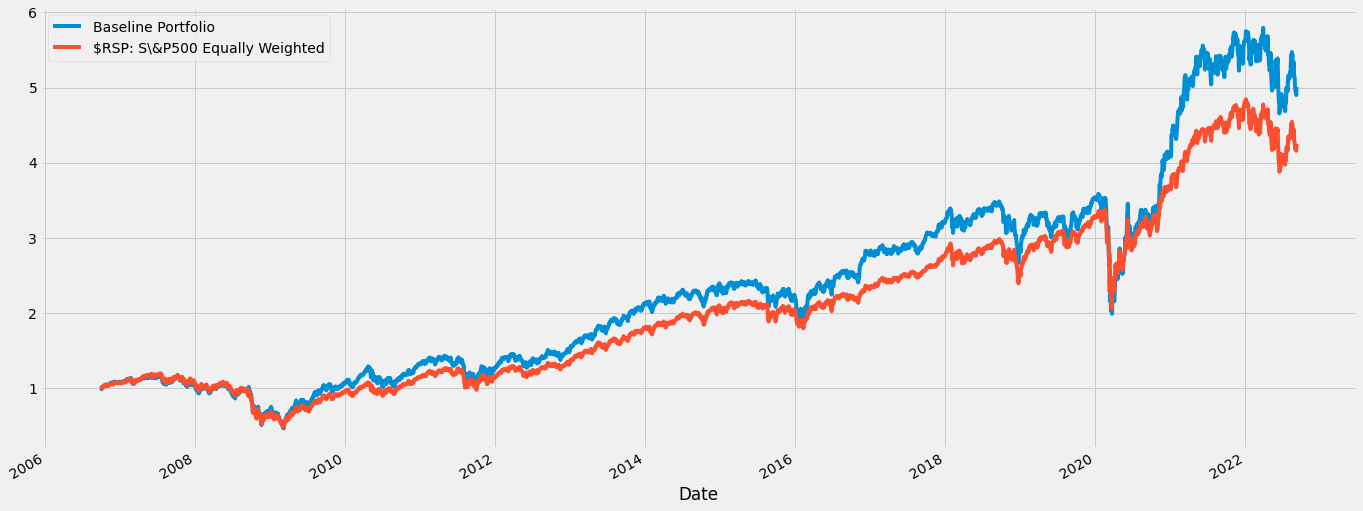

In [302]:
(1+sp500_enhanced2_prices.pct_change().mean(axis=1)).rename("Baseline Portfolio").cumprod().plot(figsize=(21,9), legend=True)
(1+rsp.pct_change()+0.002/252).rename("$RSP: S\&P500 Equally Weighted").cumprod().plot(legend=True)

In [321]:
delta = ivv.index[-1] - ivv.index[0]
delta.to_pytimedelta()

datetime.timedelta(days=5823)

In [325]:
years_since_inception = delta.to_pytimedelta().days/365.25

In [326]:
pms.net_cumreturn(sp500_enhanced2_prices.pct_change().mean(axis=1), last_row=True)**(1/years_since_inception)-1

0.09095304405906379

In [327]:
pms.net_cumreturn(rsp.pct_change(), last_row=True)**(1/years_since_inception)-1

0.07390633439153182

In [329]:
sp500_enhanced2_prices.pct_change().mean(axis=1).mean()*252

0.13386201443135345

In [332]:
rsp.pct_change().mean()*252

0.11292366082908484

In [334]:
sp500_enhanced2_prices.tail()

,A,AA,AAPL,ABC,ABT,ACCO,ADBE,ADI,ADM,ADP,...,WY,X,XEL,XOM,XRAY,XRX,YUM,ZBH,ZION,ZUMZ
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-31,128.250000,49.480000,157.220001,146.559998,102.650002,5.93,373.440002,151.529999,87.889999,243.358429,...,33.980000,22.870001,74.250000,95.589996,32.770000,16.620001,111.239998,106.320000,55.029999,25.959999
2022-09-01,128.929993,48.080002,157.960007,147.610001,104.839996,5.85,370.529999,150.690002,87.580002,244.901764,...,34.040001,21.480000,75.419998,93.870003,32.169998,16.160000,114.260002,106.800003,55.110001,25.910000
2022-09-02,128.009995,49.250000,155.809998,147.710007,102.500000,5.72,368.140015,148.630005,87.610001,237.453934,...,33.869999,21.709999,74.410004,95.589996,31.799999,15.790000,112.739998,105.570000,55.040001,25.540001
2022-09-06,129.300003,47.910000,154.529999,146.020004,102.709999,5.60,368.299988,148.229996,85.699997,237.115402,...,33.560001,21.980000,74.440002,94.949997,31.059999,15.860000,112.559998,104.930000,54.660000,26.230000
2022-09-07,131.429993,47.660000,155.960007,147.839996,104.699997,5.67,379.720001,150.699997,87.230003,240.680008,...,33.889999,23.170000,76.980003,94.139999,31.920000,16.000000,115.320000,108.580002,56.349998,27.790001


* Dumping all price components data

In [337]:
sp500_enhanced2_prices.to_csv(
    "data/config/20220907_sp500mod_price_components_data.csv",
    index_label="Date",
    index=True
)

* Checking

In [338]:
sp500 = pd.read_csv(
    "data/config/20220907_sp500mod_price_components_data.csv",
    index_col="Date",
    parse_dates=True
)

In [340]:
sp500.shape

(4013, 489)

* Stocks with prices below 1$ at some time

In [360]:
list(sp500.columns[(sp500[sp500<1].sum()!=0)])

['ACCO',
 'AXL',
 'BBW',
 'BCRX',
 'CCO',
 'CERS',
 'CHS',
 'CNO',
 'EGY',
 'EVC',
 'F',
 'FCEL',
 'FITB',
 'FLWS',
 'GERN',
 'GNW',
 'HBAN',
 'HL',
 'IBCP',
 'LVS',
 'LXP',
 'MNKD',
 'MOD',
 'MTG',
 'NR',
 'OSBC',
 'PLAB',
 'PLUG',
 'QRTEA',
 'RDN',
 'RIGL',
 'RUTH',
 'SLM',
 'SSP',
 'STAR',
 'TEN',
 'TGNA',
 'TTI',
 'WNC']

* Checking if Missing Data

In [361]:
sp500.isna().sum().sum()

0

### Annex: Metrics Comparison between SP500-Mod EW and RSP ETF (Actual SP500 EW Replica)

**NOTA** Defender la cartera baseline (`e-SP500`) como buen baseline similar a indice (sin problemas de sesgo de supervivencia), en base a metricas a 10, 5, 3 (returns y sharpes a plazo)

In [365]:
sp500.pct_change().rolling(window="3600D", min_periods=2400).apply(pms.multi_period_return)

,A,AA,AAPL,ABC,ABT,ACCO,ADBE,ADI,ADM,ADP,...,WY,X,XEL,XOM,XRAY,XRX,YUM,ZBH,ZION,ZUMZ
Date,,,,,,,,,,,,,,,,,,,,,
2006-09-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,4.433978,1.395404,7.096979,3.248310,2.910197,0.117474,10.150791,3.979036,3.111311,4.964884,...,0.752867,0.086730,2.639554,0.580804,-0.037985,0.241272,1.657840,0.870057,2.031656,0.031387
2022-09-01,4.538170,1.412462,7.409237,3.332323,3.021115,0.131699,10.123686,3.937304,3.209401,5.055778,...,0.778644,0.067753,2.711485,0.586960,-0.049071,0.272058,1.737016,0.918705,2.079129,0.011319
2022-09-02,4.446503,1.493891,7.248117,3.364773,2.919372,0.088469,10.035372,3.918293,3.267133,4.854361,...,0.789669,0.090640,2.693566,0.621432,-0.073835,0.279377,1.703695,0.892344,2.052129,-0.041651


In [377]:
sp500mod_10y_returns = sp500.pct_change().mean(axis=1).rolling(window="3600D", min_periods=2400).apply(pms.multi_period_return)

<AxesSubplot:xlabel='Date'>

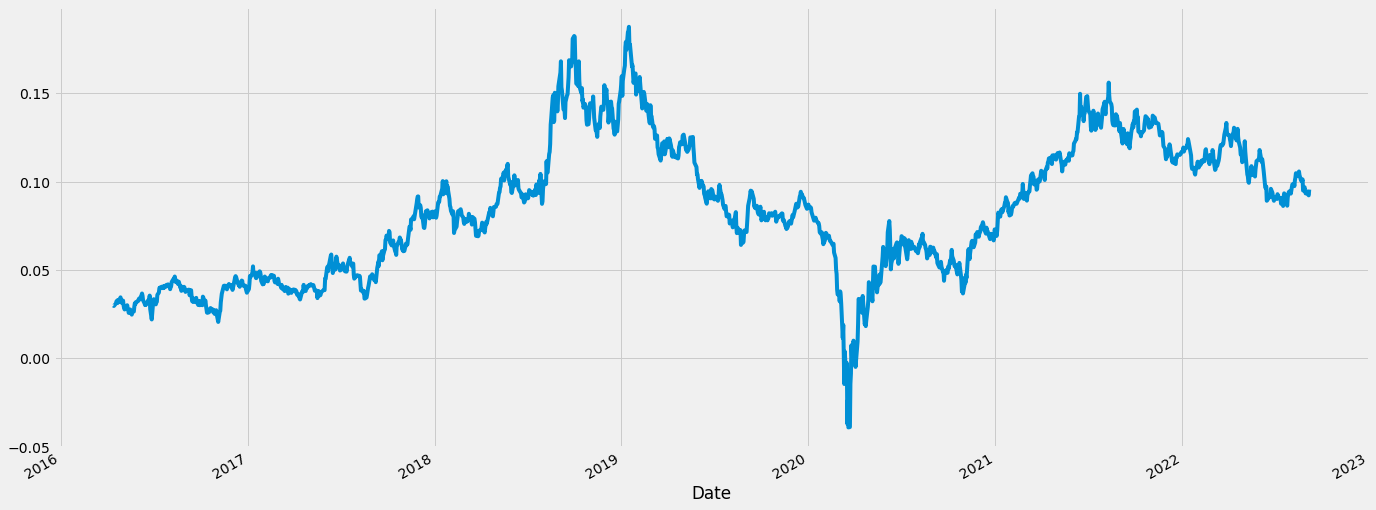

In [378]:
(sp500mod_10y_returns**(1/10)-1).plot(figsize=(21,9))

In [379]:
sp500mod_10y_returns[-1]

2.489537781734138

In [372]:
rsp_10y_returns = rsp.pct_change().rolling(window="3600D", min_periods=2400).apply(pms.multi_period_return)

In [380]:
rsp_10y_returns[-1]

2.244983628039062

* ***Translate*** to year equivalents (an excerpt from the [_Vanguard_](https://investor.vanguard.com/investment-products/etfs/profile/vthr#performance-fees) webpage):

![Returns over distinct Horizons for EW SP500-M and $RSP](./pics/returns_dashboard_template.png)